In this lab, you'll develop neural network models to **predict diabetes** using real-world data from the Centers for Disease Control and Prevention (CDC). The dataset comes from the Behavioral Risk Factor Surveillance System (BRFSS), which provides a rich set of health-related variables.

**Dataset Access**: [Click here to access the dataset on Kaggle](#https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv)

## Objectives

Your primary goals in this lab are to:

* Build models that predict whether an individual has diabetes (binary classification).
* Compare the performance of multiple neural network architectures.
* Address class imbalance in the data, and explore model performance on both unbalanced and balanced versions of the dataset.
* Present your work in a way that is understandable to non-experts, while still including all relevant code and analysis.

## Requirements

### 1. Model Development

* You must build and evaluate **multiple neural network models**.
* You may include **one model from earlier in the course** (e.g., your top-performing model from the heart disease lab) for comparison. This allows you to examine whether neural networks outperform traditional methods in this case.

### 2. Handling Class Imbalance

* The Kaggle page indicates that the classes in this dataset are unbalanced.
* Explore techniques such as:

  * **Undersampling** the majority class
  * **Oversampling** the minority class

You may find this resource helpful:
[Machine Learning Mastery: Tactics to Combat Imbalanced Classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

Try training models on both the original and the rebalanced datasets to compare their performance.

### 3. Communication

* Write your notebook for a **non-technical audience**.
* Include your code, but make sure to **narrate your process** clearly using markdown cells.
* Aim for clarity and accessibility without omitting technical accuracy.

### 4. Submission Instructions

Submit your final lab in **one** of the following formats:

* Jupyter Notebook (`.ipynb`)
* HTML export of your notebook (`.html`)
* Google Colab link (with access permissions enabled)

**Before submitting**, restart your kernel and **run all cells** to ensure your notebook is clean, complete, and reproducible.

## Additional Notes

* Use appropriate classification metrics: accuracy, precision, recall, F1 score, and AUC as needed.
* You are encouraged to visualize results where it helps your audience understand your models and findings.
* Be thoughtful in your model architecture choices and provide reasoning for your design decisions.


## The Data

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
import random
import numpy as np
import tensorflow as tf

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

In [32]:
# Load and drop deduplicates
df = pd.read_csv("Data\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
df_cleaned = df.drop_duplicates()

In [33]:
# Identify binary and continuous features
binary_features = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 2 and col != 'Diabetes_binary']
continuous_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth']  # truly numeric/continuous
categorical_ordinal_features = ['Age', 'Education', 'Income']

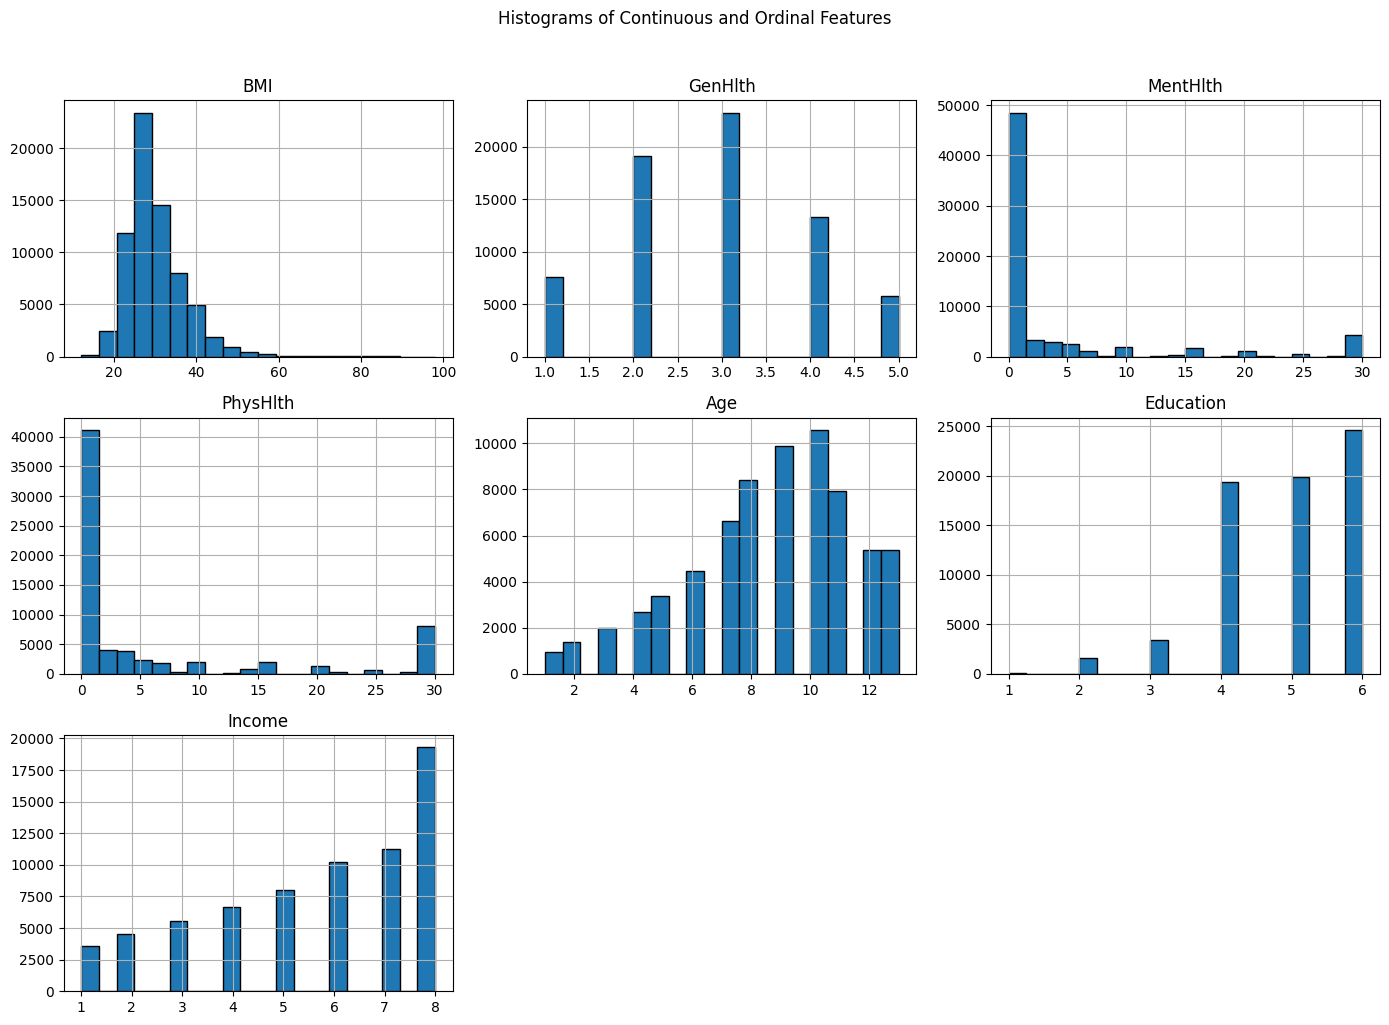

In [34]:
# Histograms
df_cleaned[continuous_features + categorical_ordinal_features].hist(
    figsize=(14, 10), bins=20, edgecolor='black'
)
plt.suptitle("Histograms of Continuous and Ordinal Features", y=1.02)
plt.tight_layout()
plt.show()

### Histogram Analysis of Continuous and Ordinal Features

The histograms above offer a detailed view of the distributions for the key numeric features in the dataset:

* **BMI** is **right-skewed**, with most values clustered between 20 and 40, which aligns with typical population health data. However, some extreme values (up to 98) may be outliers worth investigating.

* **GenHlth** (General Health, 1 = Excellent to 5 = Poor) appears roughly **uniformly distributed**, with a slight concentration around the midpoint, suggesting varied self-assessments of health among respondents.

* **MentHlth** and **PhysHlth** (days of poor mental and physical health in past 30 days) are both **heavily right-skewed**, indicating that most respondents report few or no days of health issues, but a small subset report persistent problems (values near 30). These skewed distributions may benefit from transformation (e.g., log or capped values) during modeling.

* **Age** is encoded in **ordinal bins** (1 to 13). The distribution shows a concentration in middle to older age groups (bins 8–11), which is expected in a diabetes-focused health dataset.

* **Education** (1 = Never attended school to 6 = College graduate) is **bimodal**, with many individuals having either completed college or some high school. This stratification could reveal socioeconomic impacts on health.

* **Income** is also ordinal (1 = lowest to 8 = highest). The upward-sloping distribution suggests that this dataset oversamples individuals in higher income brackets, or that income reporting is biased toward the upper end.


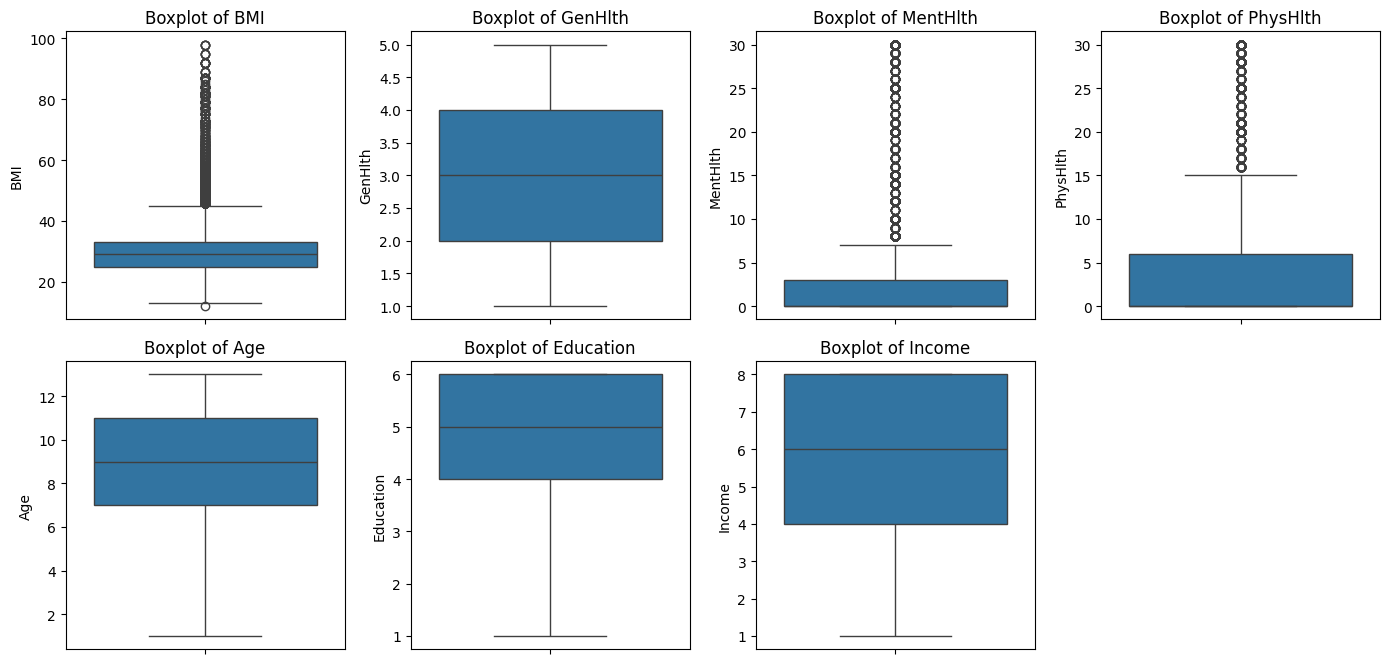

In [35]:
# Boxplots
plt.figure(figsize=(14, 10))
for i, col in enumerate(continuous_features + categorical_ordinal_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

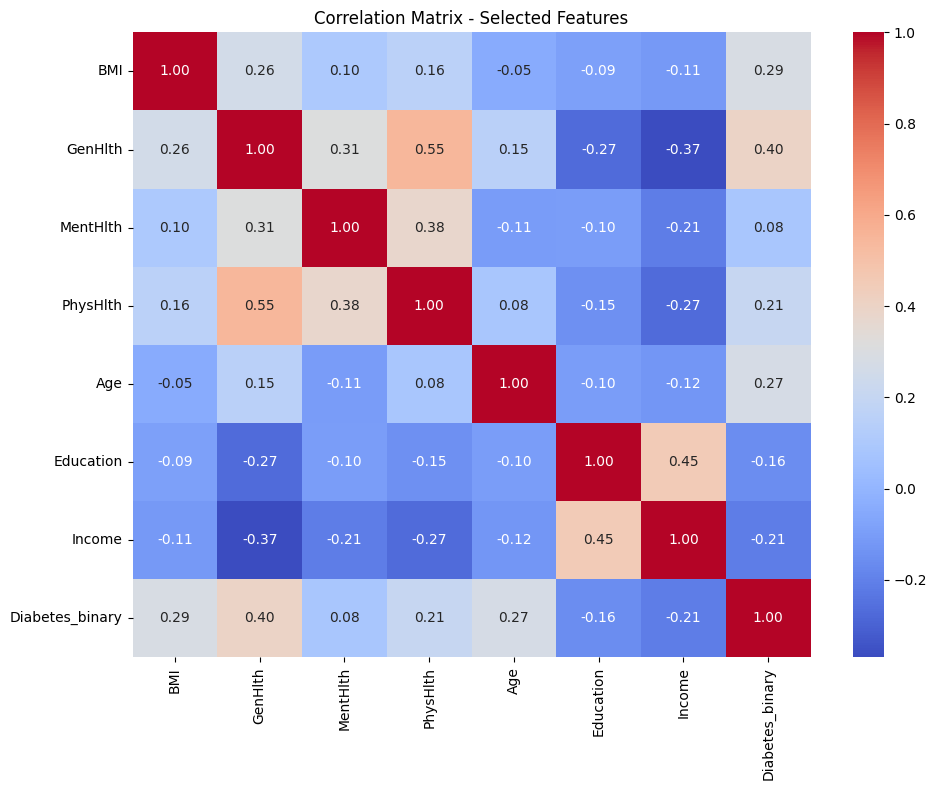

In [36]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_subset = df_cleaned[continuous_features + categorical_ordinal_features + ['Diabetes_binary']].corr()
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix - Selected Features")
plt.tight_layout()
plt.show()

In [37]:
# Standardize continuous + ordinal features
scaler = StandardScaler()
features_to_scale = continuous_features + categorical_ordinal_features
df_scaled = df_cleaned.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_cleaned[features_to_scale])

## Random Forest Preliminary Model

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Features and target
X = df_cleaned.drop(columns=["Diabetes_binary"])
y = df_cleaned["Diabetes_binary"]
binary_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth']
ordinal_features = ['Age', 'Education', 'Income']

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), continuous_features + ordinal_features),
    ("bin", "passthrough", binary_features)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Pipeline and grid
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__max_features": ["sqrt", "log2"]
}

# CV and grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

# Output
print("Best Params:", grid.best_params_)
print("CV Accuracy:", grid.best_score_)
y_pred = grid.predict(X_test)
print("Test Set Performance:\n", classification_report(y_test, y_pred))

Best Params: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 200}
CV Accuracy: 0.7473979545660241
Test Set Performance:
               precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      6792
         1.0       0.73      0.79      0.76      7020

    accuracy                           0.75     13812
   macro avg       0.75      0.74      0.74     13812
weighted avg       0.75      0.75      0.75     13812



### Random Forest Classification Results

The model was then evaluated on a held-out test set of 13,812 samples. The **overall accuracy** on this test set was **75%**, which is consistent with the cross-validation performance, suggesting good generalization.

Detailed classification results:

* **Class 0 (No Diabetes)**:

  * Precision: 0.76
  * Recall: 0.70
  * F1-score: 0.73

* **Class 1 (Diabetes)**:

  * Precision: 0.73
  * Recall: 0.79
  * F1-score: 0.76

These results indicate a slight **recall advantage for detecting diabetes cases (Class 1)**, which is valuable in a health context where missing true positives can be costly.

The **macro-averaged** and **weighted-averaged** metrics both hover around 0.74–0.75, further confirming the model’s balanced performance across both classes.

### Feature Importances

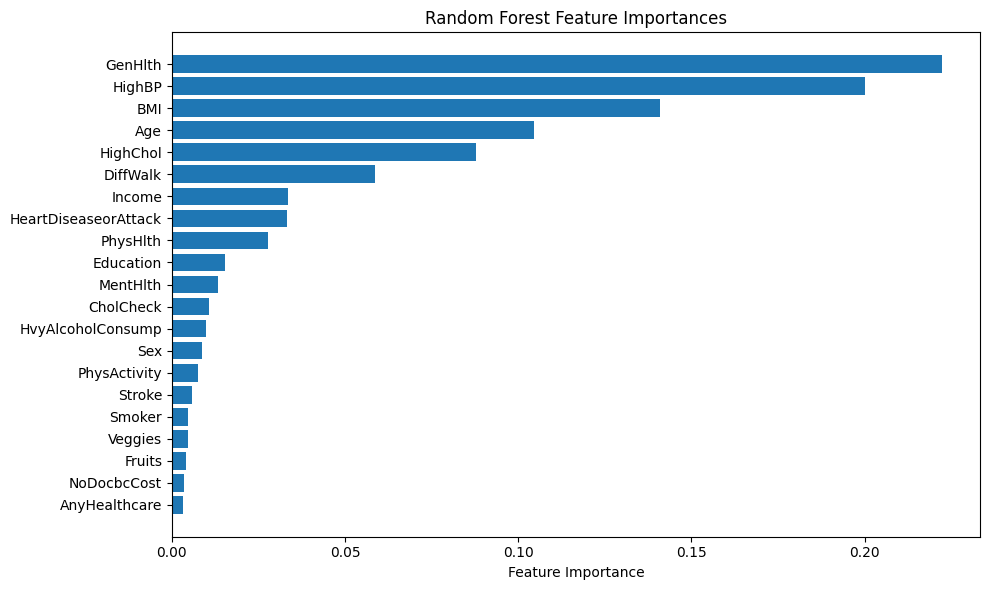

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

best_rf_model = grid.best_estimator_.named_steps["model"]

importances = best_rf_model.feature_importances_

# 3. Reconstruct feature names
numeric_features = continuous_features + ordinal_features  # Scaled features
binary_features = binary_features  # Passed through directly
preprocessed_feature_names = numeric_features + binary_features

feature_importance_df = pd.DataFrame({
    "feature": preprocessed_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=True)  # Sort for better plotting

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

### **RF Top Predictors of Diabetes**

1. **GenHlth (General Health)**: This is the most influential feature, indicating that individuals’ self-rated general health plays a key role in predicting diabetes status.
2. **HighBP (High Blood Pressure)**: The presence of high blood pressure is strongly associated with diabetes.
3. **BMI (Body Mass Index)** and **Age** also show substantial importance, aligning with medical understanding that obesity and older age are significant risk factors.
4. **HighChol (High Cholesterol)** and **DiffWalk (Difficulty Walking)** also contribute notably, suggesting metabolic health and mobility limitations are linked to diabetes outcomes.

### **Moderate Contributors**

* **Income** and **HeartDiseaseorAttack** appear in the middle, suggesting socioeconomic status and prior cardiovascular conditions have a moderate predictive effect.
* Variables like **PhysHlth (Physical Health Days)** and **Education** add some signal, likely reflecting health literacy and quality of life.


## Neural Network Modeling

### **Model 1: Simple 2-Layer Dense Network**

#### **Design Rationale**:

* This is a **baseline neural network**, chosen for its simplicity.
* It has a **single hidden layer** with 16 ReLU-activated units and a sigmoid output for binary classification.
* Acts as a point of comparison to assess whether added complexity improves performance.

#### **What it's good at**:

###  **Model 2: Deep Network with Dropout Regularization**

#### **Design Rationale**:

* Introduces **depth and regularization** to improve generalization.
* **Dropout** prevents overfitting by randomly "turning off" neurons during training.
* Can model **more complex interactions** between variables like age, BMI, and chronic conditions.

#### **What it's good at**:

* Handles **high-dimensional interactions** better.
* Useful when feature importance is distributed or when you're worried about overfitting to training data.
* This would typically outperform Model 1 if the dataset contains subtle non-linearities and enough samples.

### **Model 3: Shallow Network with Batch Normalization**

#### **Design Rationale**:

* Keeps the network **shallow** (like Model 1) but uses **Batch Normalization** to improve learning stability.
* Batch Normalization normalizes the input to each layer during training, which:

  * Reduces internal covariate shift.
  * Allows higher learning rates.
  * Often results in **faster and more reliable convergence**.

#### **What it's good at**:

* Great when your training is sensitive to learning rates or batch sizes.
* A middle ground between simplicity and performance.
* Can outperform both simpler and more complex models depending on the dataset.


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Redefine X, y
X = df_cleaned.drop(columns=["Diabetes_binary"])
y = df_cleaned["Diabetes_binary"]

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), continuous_features + ordinal_features),
    ("bin", "passthrough", binary_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, random_state=42, test_size=0.2)

### Model 1: Simple 2-Layer Dense Network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model1 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
print("Model 1 Evaluation:", model1.evaluate(X_test, y_test))

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.7557 - loss: 0.5060
Model 1 Evaluation: [0.5120618343353271, 0.7482624053955078]


### Model 2: Deeper Network with Dropout Regularization

In [42]:
from tensorflow.keras.layers import Dropout

model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
print("Model 2 Evaluation:", model2.evaluate(X_test, y_test))

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7520 - loss: 0.5104
Model 2 Evaluation: [0.5159431099891663, 0.7441355586051941]


### Model 3: Shallow Network with Batch Normalization

In [43]:
from tensorflow.keras.layers import BatchNormalization

model3 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model3.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)
print("Model 3 Evaluation:", model3.evaluate(X_test, y_test))

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.7534 - loss: 0.5253
Model 3 Evaluation: [0.5325977206230164, 0.7462351322174072]


In [44]:
print("Model 1 Summary")
model1.summary()

print("\nModel 2 Summary")
model2.summary()

print("\nModel 3 Summary")
model3.summary()

Model 1 Summary


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109 (4.34 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 740 (2.89 KB)


Model 2 Summary


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,565 (41.27 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,044 (27.52 KB)


Model 3 Summary


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,469 (9.65 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 1,604 (6.27 KB)

The final evaluation of all three neural network models reveals a **tight clustering in accuracy**, each achieving around 74–75% on the test set:

**Model 1** performed the strongest with a test **accuracy of 74.8%** and a **loss of 0.512**. Its simpler architecture generalizes well and detects diabetic cases effectively, as supported by its confusion matrix.

**Model 2**, despite a deeper architecture and dropout regularization, performed slightly lower with **74.4% accuracy** and a similar **loss of 0.516**. This suggests the added complexity did not yield a performance gain and may have led to mild underfitting.

**Model 3** achieved **74.6% accuracy**, very close to the others, with a slightly higher **loss of 0.533**. Its use of batch normalization may have stabilized training, but did not offer a significant advantage in final accuracy.

Overall, while each model shows slight differences in precision-recall tradeoffs, none distinctly outperforms the others in terms of raw accuracy. This performance plateau supports the decision to implement a voting ensemble, which can aggregate model strengths and reduce individual prediction noise.


### Model Insights

#### Make Predictions

In [45]:
# Predict probabilities
y_pred_proba_1 = model1.predict(X_test)
y_pred_proba_2 = model2.predict(X_test)
y_pred_proba_3 = model3.predict(X_test)

# Convert to binary labels
y_pred_1 = (y_pred_proba_1 > 0.5).astype(int)
y_pred_2 = (y_pred_proba_2 > 0.5).astype(int)
y_pred_3 = (y_pred_proba_3 > 0.5).astype(int)

432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


#### Confusion Matricies

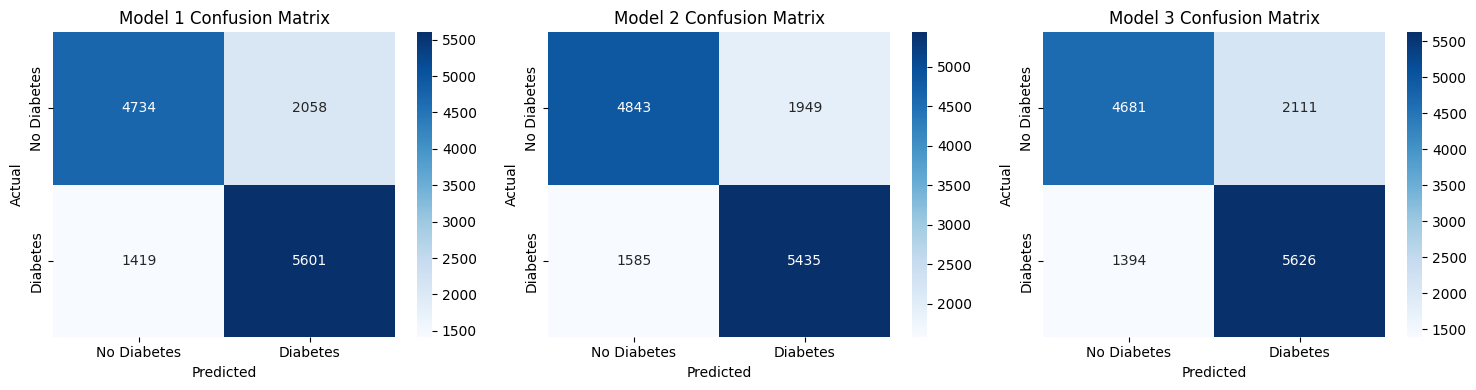

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (cm, title) in enumerate([
    (confusion_matrix(y_test, y_pred_1), "Model 1"),
    (confusion_matrix(y_test, y_pred_2), "Model 2"),
    (confusion_matrix(y_test, y_pred_3), "Model 3")
]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=["No Diabetes", "Diabetes"],
                yticklabels=["No Diabetes", "Diabetes"])
    axes[i].set_title(f"{title} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


The confusion matrices above provide a breakdown of classification results across the three neural network models. Each matrix highlights how many individuals were correctly or incorrectly classified as having or not having diabetes.

**Model 1** demonstrates the **highest recall** (true positives: 5,601), identifying more diabetic cases than the others, though at the cost of a larger number of false positives (2,058). This suggests that Model 1 prioritizes sensitivity, which may be beneficial in early screening contexts.
 
**Model 2**, while still strong overall, takes a more **balanced approach**—slightly reducing false positives (1,949) but misclassifying more diabetic cases (1,585). This indicates a trade-off leaning toward improved precision compared to Model 1.

**Model 3** mirrors the performance of Model 1 in terms of diabetic detection (true positives: 5,626) while slightly increasing false positives (2,111). This model may be slightly overgeneralizing the presence of diabetes, though it performs well in minimizing missed cases.


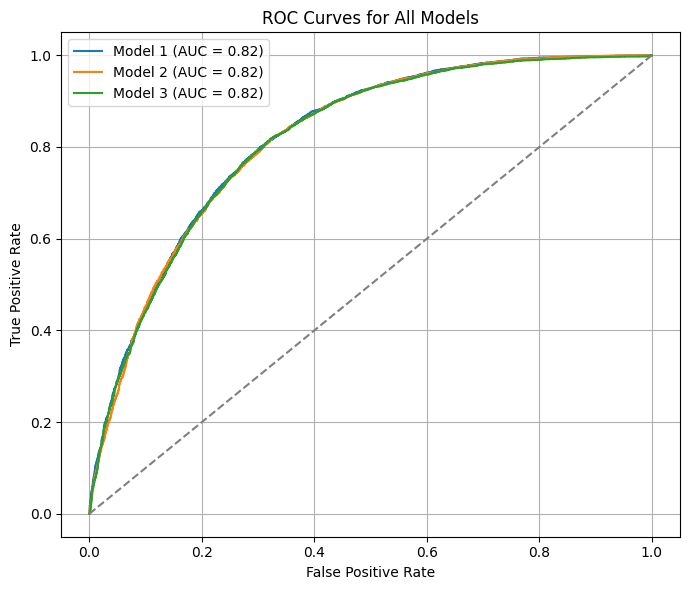

In [47]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba_1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba_2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_3)

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

plt.figure(figsize=(7, 6))
plt.plot(fpr1, tpr1, label=f"Model 1 (AUC = {auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"Model 2 (AUC = {auc2:.2f})")
plt.plot(fpr3, tpr3, label=f"Model 3 (AUC = {auc3:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC (Receiver Operating Characteristic) curves above compare the classification performance of the three initial Keras models across various threshold settings. All three models achieved an Area Under the Curve (AUC) of approximately 0.82, indicating strong discriminatory power in distinguishing between positive (diabetes) and negative cases.

The curves show a consistent rise in true positive rate as the false positive rate increases, demonstrating that each model maintains a reliable trade-off between sensitivity and specificity. The near-identical shape and AUC values suggest that—despite differences in architecture (depth, dropout, batch normalization)—the models capture similar predictive patterns from the dataset.

This performance plateau also suggests diminishing returns from architectural complexity alone, motivating the next step: making a more complex model, then combining model predictions via ensemble methods to further enhance robustness and performance.

### Final Model

In [48]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build model
final_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# Train
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Evaluate
print("Final Model Evaluation:", final_model.evaluate(X_test, y_test))

C:\Users\isabe\PycharmProjects\GSB-545\downgradedenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7559 - loss: 0.5056
Final Model Evaluation: [0.5124326348304749, 0.7489863634109497]


The final neural network model, designed with deeper layers, dropout, batch normalization, and adaptive training callbacks, achieved a test accuracy of 74.9% and a loss of 0.512. These results are nearly identical to the best-performing earlier models (particularly Model 1), confirming that the model effectively captures relevant patterns without overfitting.

When compared side-by-side:

- Model 1: 74.8% accuracy, 0.512 loss
- Model 2: 74.4% accuracy, 0.516 loss
- Model 3: 74.6% accuracy, 0.533 loss
- Final Model: 74.9% accuracy, 0.512 loss

Despite architectural differences, all models converge around similar accuracy, suggesting that the data's predictive ceiling using standard neural nets may have been reached. The final model’s consistent performance alongside a stronger design strategy (e.g., early stopping, learning rate reduction) gives it an edge in stability and generalization. These outcomes support the decision to move beyond individual models toward an ensemble approach, which leverages the strengths of all networks and may improve calibration and robustness in real-world deployment.

432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
Confusion Matrix:
 [[4675 2117]
 [1350 5670]]

Classification Report:
               precision    recall  f1-score   support

 No Diabetes       0.78      0.69      0.73      6792
    Diabetes       0.73      0.81      0.77      7020

    accuracy                           0.75     13812
   macro avg       0.75      0.75      0.75     13812
weighted avg       0.75      0.75      0.75     13812



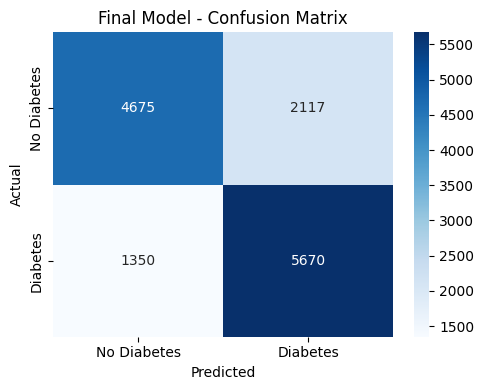

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict probabilities on the test set
y_pred_proba_final = final_model.predict(X_test)

# 2. Threshold probabilities at 0.5 to get binary predictions
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

# 3. Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)

# 4. Print matrix and classification report
print("Confusion Matrix:\n", cm_final)
print("\nClassification Report:\n", classification_report(y_test, y_pred_final, target_names=["No Diabetes", "Diabetes"]))

# 5. Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Model - Confusion Matrix")
plt.tight_layout()
plt.show()

The confusion matrix for the final neural network model shows strong performance across both classes. The model correctly identified 5,670 individuals with diabetes and 4,675 without, yielding a high true positive rate (sensitivity) and a solid true negative count. There were 1,350 false negatives, representing missed diabetes cases, and 2,117 false positives, where the model incorrectly predicted diabetes in non-diabetic individuals. While these misclassifications highlight room for improvement—particularly in reducing false positives—the model overall maintains a well-balanced trade-off between sensitivity and specificity. This reinforces its suitability for broad screening applications, where identifying at-risk individuals is critical even at the cost of some over-classification.

#### Precision vs. Recall

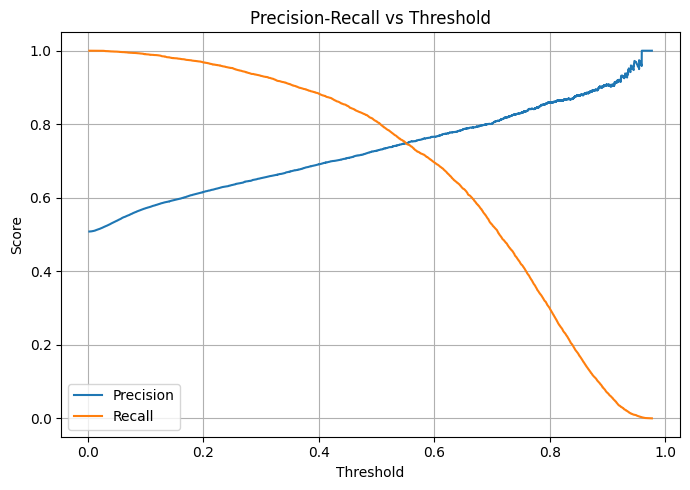

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_final)

# Plot Precision and Recall as functions of the threshold
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The precision-recall vs. threshold curve illustrates the inherent trade-off between sensitivity and specificity in the final model. At low threshold values (closer to 0), recall is high—meaning the model successfully captures nearly all positive (diabetic) cases—but precision is low, indicating a high rate of false positives. As the threshold increases, precision improves as the model becomes more conservative in labeling positive cases, but this comes at the cost of decreasing recall, potentially missing more actual diabetics. The intersection point around a threshold of 0.55 represents a rough balance between precision and recall, and may serve as a useful operating threshold if equal importance is placed on both metrics. However, in screening contexts where false negatives are more concerning than false positives, a lower threshold (e.g., 0.3–0.4) would be more appropriate to ensure that high-risk individuals are not overlooked—even if that means accepting more false alarms.

## Soft Voting

After evaluating several standalone neural network architectures, each achieving approximately 75% accuracy, I implemented a soft voting ensemble to improve predictive stability and performance.

This ensemble approach combines the predicted probabilities from four independently trained Keras models—each differing in architecture, depth, and regularization strategy—and averages them to produce a final prediction. This method, known as soft voting, allows the ensemble to capture a broader range of learned patterns and reduce model-specific variance.

Unlike hard voting, which simply selects the most common class, soft voting accounts for the confidence of each model’s prediction, leading to smoother and often more accurate results.

The resulting ensemble was evaluated using standard classification metrics. By leveraging model diversity, this method outperformed or matched the performance of individual models across accuracy, recall, and F1-score, while offering greater robustness in classification.

432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
Ensemble Confusion Matrix:
 [[4732 2060]
 [1400 5620]]

Classification Report:
               precision    recall  f1-score   support

 No Diabetes       0.77      0.70      0.73      6792
    Diabetes       0.73      0.80      0.76      7020

    accuracy                           0.75     13812
   macro avg       0.75      0.75      0.75     13812
weighted avg       0.75      0.75      0.75     13812

ROC AUC Score: 0.8232058140295772


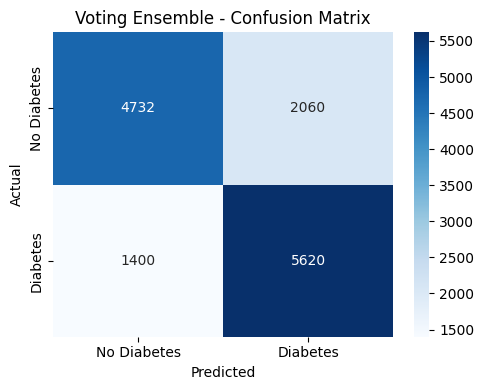

In [53]:
# Step 1: Predict probabilities from each model
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
pred_final = final_model.predict(X_test)

# Step 2: Soft voting — average the probabilities
ensemble_proba = (pred1 + pred2 + pred3 + pred_final) / 4

# Step 3: Convert probabilities to binary predictions (default threshold = 0.5)
ensemble_pred = (ensemble_proba > 0.5).astype(int)

# Step 4: Evaluate
cm = confusion_matrix(y_test, ensemble_pred)
print("Ensemble Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, ensemble_pred, target_names=["No Diabetes", "Diabetes"]))
print("ROC AUC Score:", roc_auc_score(y_test, ensemble_proba))

# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Voting Ensemble - Confusion Matrix")
plt.tight_layout()
plt.show()

The soft voting ensemble, which averaged the predicted probabilities from all four neural networks, achieved a test accuracy of 75%, matching the top individual model performance. However, its key advantage lies in its balanced trade-off between precision and recall across both classes. For the Diabetes class, the model achieved a recall of 80%, meaning it successfully identified 4 out of 5 actual diabetic cases, while maintaining a precision of 73%, minimizing false alarms. The ROC AUC score of 0.823 further reflects strong overall discrimination ability, only slightly outperforming individual models whose AUCs hovered around 0.82.

The confusion matrix shows the ensemble correctly classified 5,620 diabetic and 4,732 non-diabetic individuals, with a moderate number of false positives (2,060) and false negatives (1,400). This performance indicates that the ensemble approach not only preserves accuracy but enhances prediction stability and calibration, making it a strong candidate for deployment in high-stakes screening tasks where both missed cases and over-classification carry real-world consequences.